In [1]:
from sympy.physics.optics import RayTransferMatrix, ThinLens, BeamParameter, FreeSpace
from sympy import symbols, init_printing, pi, sqrt, pprint, solveset, S, plot, cos
from scipy.constants import c
import matplotlib.pyplot as plt
import numpy as np
init_printing()
from ipywidgets.widgets import (IntSlider, FloatLogSlider, FloatSlider, interactive_output, 
                                FloatRangeSlider, BoundedFloatText, Checkbox, HBox, VBox, IntRangeSlider, 
                                BoundedIntText, Text, Button, Label)
from IPython.display import display
import datetime, os


Confocal length: $Z_c$, Radius of the curvature of beam wave front: R(z) and the Beam radius: w(z) are defined such as: 



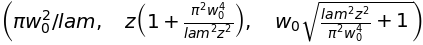

In [2]:
w, lam, w0, z = symbols("w, lam, w0, z", positive=True)

# defining the confocal length, R(z) and w(z) in sympy
z_r = pi * w0 ** 2 / lam
R = z*(1 + (z_r / z) ** 2)
w = w0 * sqrt(1 + (z / z_r) ** 2)

# Defining the z-propagation range
z_ = np.linspace(0, 20, 10)

# Defining functions
def ghz_cm(x): return c * 1e2 / x * 1e-9

print('Confocal length: $Z_c$, Radius of the curvature of beam wave front: R(z) and the Beam radius: w(z) are defined such as: \n')

z_r, R, w

In [3]:
class gaussian_simulation:
    def __init__(self):

        W = BoundedFloatText(value=0.37, min=0.1, max=1, step=0.01, description="w0:")
        L = IntRangeSlider(
            value=[380, 1200], min=100, max=1500, step=1, description="GHz"
        )

        width = BoundedIntText(value=16, min=5, max=25, step=1, description="width")
        height = BoundedIntText(value=9, min=5, max=25, step=1, description="height")
        dpi = BoundedIntText(value=106, min=70, max=250, step=1, description="Dpi")

        entry1 = BoundedFloatText(
            value=-8.4, min=-10, max=10, step=0.1, description="Entry1"
        )
        entry2 = BoundedFloatText(
            value=2, min=0, max=10, step=0.1, description="Entry2"
        )

        self.save_name = Text(value="")

        save_button = Button(description="Save", layout={"width": "300px"})

        save_button.on_click(self.save_plot)

        self.print_save = Label(value="Status: ")

        row1 = HBox([W, L])
        row2 = HBox([width, height, dpi])
        row3 = HBox([entry1, entry2])

        out = interactive_output(
            self.simulate,
            {
                "w0_": W,
                "wn": L,
                "width": width,
                "height": height,
                "dpi": dpi,
                "entry1": entry1,
                "entry2": entry2,
            },
        )

        display(
            VBox([row1, row2, row3, out, self.save_name, save_button, self.print_save])
        )

    def save_plot(self, event):

        self.fig0.savefig(f"./{self.save_name.value}.png")

        t = datetime.datetime.now()
        self.print_save.value = f'File "{self.save_name.value}.png" Saved; {t.ctime()}'

    def beam_plot(self, ax, w0_, wn):

        self.gaussian_beam(w0_, wn)

        for c, beam in enumerate(self.beams):
            color = f"C{c}"
            ax.plot(
                z_,
                beam,
                f"--{color}",
                label=f"{self.wn[c]:.2f} GHz ({ghz_cm(self.wn[c])*10:.2f} mm)",
            )
            ax.plot(-z_, -beam, f"--{color}")
            ax.plot(-z_, beam, f"--{color}")
            ax.plot(z_, -beam, f"--{color}")

    def simulate(self, w0_, wn, width, height, dpi, entry1, entry2):

        self.fig0, ax0 = plt.subplots(figsize=(width, height), dpi=dpi)
        self.beam_plot(ax0, w0_, wn)

        ax0.hlines(0, xmin=-z_.max(), xmax=z_.max())

        ## Annotation begins

        # Distance b/w two entry points
        ax0.hlines(-0.2, xmin=entry1, xmax=entry2)
        plt.annotate(
            s=f"d={(entry2-entry1):.2f}",
            xy=(0, 0),
            xytext=(0, -0.3),
            ha="center",
            va="center",
        )

        # Annotate beam waist
        ax0.vlines(x=0, ymin=0, ymax=w0_)
        plt.annotate(
            s=f"w0={w0_} cm",
            xy=(0, w0_),
            xytext=(0, 0.7),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
        )

        # Annotate Entry1
        ax0.vlines(x=entry1, ymin=-1, ymax=1)

        plt.annotate(
            s="Main entry window: diameter=2cm",
            xy=(entry1, 1),
            xytext=(entry1 + 5, 1.1),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
        )

        # Annotate Entry2
        ax0.vlines(x=entry2, ymin=-0.43, ymax=0.43)

        plt.annotate(
            s="Trap bender entry: diameter=0.86cm",
            xy=(entry2, -0.43),
            xytext=(entry2 - 5, -0.7),
            ha="center",
            va="center",
            #rotation = 30,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
        )

        # Annotate z-position

        plt.annotate(s="z=0", xy=(0, 0), xytext=(0, -0.05), ha="center", va="center")

        plt.annotate(
            s=f"z={entry2}",
            xy=(entry2, 0),
            xytext=(entry2 + 2, -0.2),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
        )

        plt.annotate(
            s=f"z={entry1}",
            xy=(entry1, 0),
            xytext=(entry1 - 2, -0.2),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
        )

        ## Annotation ends

        ax0.set_xlabel("z direction : Beam Propagation (cm)")
        ax0.set_ylabel("w(z) : Gaussian Beam radius (cm)")
        ax0.set_title(f"Gaussian Beam simulation: {wn[0]}-{wn[-1]} GHz")
        ax0.legend()
        plt.show()
        # plt.close()

        self.save_name.value = f"{w0_}cm-{wn[0]}-{wn[-1]}GHz_simulation"

    def gaussian_beam(self, w0_, wn):

        global w, z_

        self.wn = np.linspace(*wn, 10)

        beam = []
        beams = []

        for l in self.wn:

            temp = []
            beam = []

            for i in z_:
                temp = float(w.subs({w0: w0_, lam: ghz_cm(l), z: i}).evalf())
                beam.append(temp)
            beams.append(beam)

        self.beams = np.array(beams)

# Simulating Gaussian beam propagation from inside FELion Trap

We will try to obtain the optimum conditions such the waist radius w0 and distance to the w0 from outside mirror, etc.

In [4]:
#%matplotlib widget
%matplotlib inline
start = gaussian_simulation()

In [5]:
plt.close('all')

# Mode Matching (Goldsmith Book)

Quasioptical system designers are often required to couple the power in a beam (e.g., that produced by a feed hom) to a specified beam waist radius (e.g., that required by some component in a receiver system). Dealing with beam transformation from this perspective is often called mode matching

In practice most often the case is: We are given the input and output waist radii, and thus the magnification, together with the input distance. Solving for the required focal length, we obtain

In [6]:
M, E, d_in, d_out, w0_in, w0_out, Z_c = symbols('M, E, d_in, d_out, w0_in, w0_out, Z_c')

fp = Z_c*(d_in/(E*Z_c))*(1+sqrt(1-E*(1+(d_in/Z_c)**-2)))
fm = Z_c*(d_in/(E*Z_c))*(1-sqrt(1-E*(1+(d_in/Z_c)**-2)))

## Positive and negative focus "f" for M>1

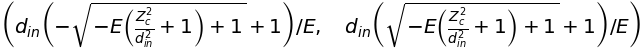

In [7]:
fm, fp

For M=1
Focus is given by:


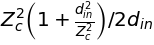

In [8]:
f1 = Z_c*(1+(d_in/Z_c)**2)/(2*d_in/Z_c)
print('For M=1\nFocus is given by:')
f1

In [9]:
class f_soln:
    def __init__(self):
        mag = BoundedFloatText(value=2.05, min=0.1, max=10, step=0.01, description="M: ")
        W = BoundedFloatText(
            value=0.37, min=0.1, max=1, step=0.01, description="w0_in: "
        )
        R1 = BoundedFloatText(value=12, min=5, max=20, step=0.1, description="R1: ")
        L = IntRangeSlider(
            value=[50, 1000], min=50, max=1500, step=1, description="GHz"
        )

        width = BoundedIntText(value=12, min=5, max=25, step=1, description="width")
        height = BoundedIntText(value=6, min=5, max=25, step=1, description="height")
        dpi = BoundedIntText(value=150, min=70, max=250, step=1, description="Dpi")

        self.save_name = Text(value="")

        save_button = Button(description="Save", layout={"width": "300px"})

        save_button.on_click(self.save_plot)

        self.print_save = Label(value="Status: ")

        row1 = HBox([width, height, dpi])
        row2 = HBox([mag, W, R1, L])

        out = interactive_output(
            self.plot,
            {
                "M": mag,
                "r1": R1,
                "w0_in": W,
                "lam": L,
                "width": width,
                "height": height,
                "dpi": dpi,
            },
        )

        display(VBox([row1, row2, out, self.save_name, save_button, self.print_save]))

    def plot(self, M, r1, w0_in, lam, width, height, dpi):

        wn = np.linspace(*lam, 50)

        x, y1, y2 = [], [], []
        no_soln, soln = [], []
        for l in wn:
            zc = np.pi * w0_in ** 2 / ghz_cm(l)

            temp0 = r1 / zc
            x.append(temp0)

            try:

                if not M == 1:
                    temp1 = fm / zc
                    temp1_1 = float(
                        temp1.subs({E: 1 - M ** -2, d_in: r1, Z_c: zc}).evalf()
                    )
                elif M == 1:
                    temp1 = f1 / Zc
                    temp1_1 = float(temp1.subs({d_in: r1, Z_c: zc}).evalf())

                y1.append(temp1_1)
                soln.append(round(l, 2))
            except:
                no_soln.append(round(l, 2))

        self.fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(width, height), dpi=dpi)

        x_ = x[: len(y1)]
        axs.plot(x_, y1, "x--", label=f"f/$Z_c$: M={M}; $w0(trap)$={w0_in}cm;"+ '$d_{in}$=%.2f cm'%r1)
        if len(no_soln) > 0 and len(soln) > 0:
            print(
                f"Solution: Exists for {soln[0]}-{soln[-1]} GHz\n\nDoes not exist for: {no_soln[0]}-{no_soln[-1]} GHz"
            )
        if len(soln) < 1:
            print(f"x: {x}\ny: {y1}")

        axs.set_xlabel("$d_{in}$/$Z_c$")
        axs.set_ylabel("f/$Z_c$")
        axs.set_title("Focal length required for mode matching as a function of $d_{in}$/$Z_c$ for a fixed M")
        
        try:
            plt.legend(title=f"Solution exist for {soln[0]}-{soln[-1]} GHz")
            self.save_name.value = f"M-{M}_{soln[0]}-{soln[-1]}GHz_din_{r1}cm"
        except: 
            pass
        plt.show()

    def save_plot(self, event):

        self.fig.savefig(f"./{self.save_name.value}.png")

        t = datetime.datetime.now()
        self.print_save.value = f'File "{self.save_name.value}.png" Saved; {t.ctime()}'


start = f_soln()

# Thin lens (Goldsmith)

Thin lens of focal length $f_{lens}$

In [10]:
f_lens = symbols('f_lens')
M_lens = ThinLens(f_lens)
M_lens

⎡  1    0⎤
⎢        ⎥
⎢ -1     ⎥
⎢─────  1⎥
⎣fₗₑₙₛ   ⎦

# Ellipsoidal mirror (Goldsmith)
An ellipsoidal mirror in the geometrical optics limit, transforms radiation from a point source at one focal point to a point source located at the second focal point; this is true for any part of the ellipsoidal surface of revolution,
formed by rotating the ellipse about the line joining its foci. 

First consider a lens that has a focal length equal to the distance from the first focal point to the center of the part of the ellipsoidal surface being used (R J). 
This lens will collimate the radiation from the first focal point into a parallel beam. 

If we immediately follow this first lens by a second, having focal length equal to the distance from the center of the mirror to the second focal point (R2) , the second lens will bring the parallel beam to a focus at the desired position. 

Thus, the ABCD matrix for an ellipsoidal mirror is the product of two matrices, each representing a thin lens, and having zero separation:

where R1 and R2 are the distances from the center of the section of the ellipsoid used to the respective foci

In [11]:
R1, R2 = symbols('R1, R2')
M_l1 = ThinLens(R1)
M_l2 = ThinLens(R2)
M_d = FreeSpace(0)
M_ellipsoid = M_l2*M_d*M_l1
M_ellipsoid

⎡    1      0⎤
⎢            ⎥
⎢  1    1    ⎥
⎢- ── - ──  1⎥
⎣  R₂   R₁   ⎦

## So that comparing with the expression for the thin lens, we see that

Effective focal length of an elliptical mirror: f_ellipsoid is given by



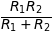

In [12]:
f_ellipsoid = 1/(1/R1+1/R2)
print('Effective focal length of an elliptical mirror: f_ellipsoid is given by\n')
f_ellipsoid.simplify()

# Assuming for the case of our ellipse, 
$$d_{in} = R1$$  $$f = f_{ellipsoid}$$ 

we can solve for R2 i.e., $d_{out}$


## The eccentricity can also be defined in terms of R1, R2, and the angle α between input and output beams (Goldsmith, 1998)

Eccentricity of the elliptical mirror in terms of R1 and R2



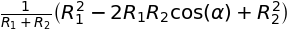

In [13]:
alpha = symbols('alpha')
e = (R1**2 + R2**2 - 2*R1*R2*cos(alpha))/(R1 + R2)
print('Eccentricity of the elliptical mirror in terms of R1 and R2\n')
e

For our case, alpha = 90, we get eccentricity as: 



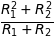

In [14]:
print('For our case, alpha = 90, we get eccentricity as: \n')
e_ellipsoid = e.subs({alpha:pi/2}).evalf()
e_ellipsoid

Eccentricity of an elliptical mirror is already defined as :



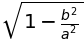

In [15]:
a, b = symbols('a, b')
print('Eccentricity of an elliptical mirror is already defined as :\n')

e_standard = sqrt(1-b**2/a**2)
e_standard

where a and b are the semi-major and semi-minor axis respectivey.

In [16]:
print('The semi-major axis a is also defined as: \n')
a = (R1 + R2)/2
a

The semi-major axis a is also defined as: 

